# Dust Extinction and Temperature

Dust in the interstellar medium causes extinction of light from distant objects, filtering out shorter wavelengths and making objects appear "redder" in observations than their intrinsic color. 

The spectral emission of a blackbody is determined by its temperature. Blackbody radiation, acting as an idealized model for stars, can be used to study the theoretical effects of interestellar reddening on observations. Later, we will use more detailed models of star spectra and compare the same processes.

Please note: in order to model a wider range of wavelengths at high temperatures, I had to make a modification to my installation of synphot. In the directory where synphot is installed, I modified ```models.py```: class ```BlackBody1D```, function ```sampleset``` takes the argument ```factor_bbox```, which I changed from 10.0 to 35.0 to widen the sampled range of wavelengths. I'll try and make this change more accessible in the future, and possibly create a fork of synphot itself.

We start by importing the required packages:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from dust_extinction.dust_extinction import CCM89
from synphot import units, SourceSpectrum, SpectralElement, Observation, ExtinctionModel1D
from synphot.models import BlackBodyNorm1D
from synphot.spectrum import BaseUnitlessSpectrum
from synphot.specio import read_remote_spec

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

import ipywidgets as widgets
from ipywidgets import interact
%matplotlib inline

Now that we have everything, we create a model of astronomical reddening under average conditions:

In [3]:
Rv = 3.1
Av = 2.0
ext = CCM89(Rv=Rv)
wav = np.arange(0.1, 3, 0.001)*u.micron

## Blackbody Data

Now that we have a model for interstellar reddening across a range of wavelengths, let's see what happens to the spectra of theoretical perfect blackbody stars across a range of temperatures when viewed through the interstellar medium.

First, we calculate the color excess for two color indexes in the near-infrared, E(H-K) and E(J-H):

In [4]:
#Defines our color passbands using synphot's filters
v_band = SpectralElement.from_filter('johnson_v')
h_band = SpectralElement.from_filter('bessel_h')
j_band = SpectralElement.from_filter('bessel_j')
k_band = SpectralElement.from_filter('bessel_k')

ex = SpectralElement(ExtinctionModel1D, points = wav, lookup_table = ext.extinguish(wav, Av = Av))
vega = SourceSpectrum.from_vega()
vmag = 10.0

#Creates a range of temperatures, baseed on Hertzprung-Russel Diagram values
temps = np.geomspace(200, 40000, num=100)

#A simple function to simplify finding flux to a single input
def flux(spec):
    fluxout = spec.effstim(flux_unit='vegamag', vegaspec=vega)
    return fluxout

#Takes an array of temperatures and two passbands, and returns E(bandplus-bandminus) for each temperature
def ColorExcess(temperature, bandplus, bandminus):
    excs=[] 
    
    for t in temperature:
        bb = SourceSpectrum(BlackBodyNorm1D, temperature = t)
        bb_norm = bb.normalize(vmag*units.VEGAMAG, v_band, vegaspec = vega)
        bb_ext = bb_norm*ex
        
        plus_int = Observation(bb_norm, bandplus, force = 'extrap')
        minus_int = Observation(bb_norm, bandminus, force = 'extrap')
        plus_obs = Observation(bb_ext, bandplus, force = 'extrap')
        minus_obs = Observation(bb_ext, bandminus, force = 'extrap')
        
        #Calculate E(bandplus - bandminus) at given temperature and append array of color excesses
        exc = ((flux(plus_obs) - flux(minus_obs)) - (flux(plus_int) - flux(minus_int)))
        excs.append(exc.value)
    
    return excs

Ejh = ColorExcess(temps, j_band, h_band)
Ehk = ColorExcess(temps, h_band, k_band)

Now that we have our data, let's plot and evaluate the results:

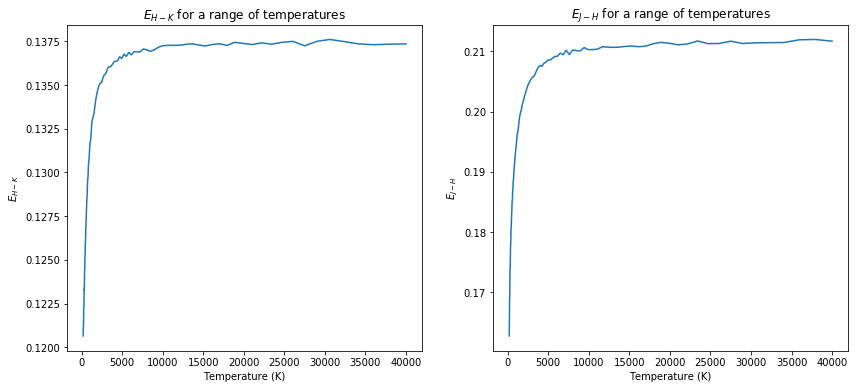

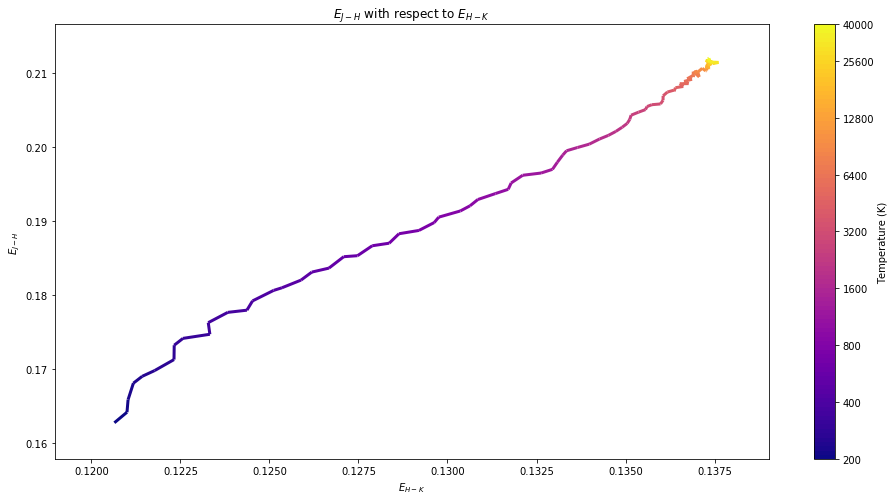

In [5]:
#Set up aesthetic parameters for our plots
zticks=[200, 400, 800, 1600, 3200, 6400, 12800, 25600, 40000]
limx = ((Ehk[0])-.1*(Ehk[len(Ehk)-1]-Ehk[0]), Ehk[len(Ehk)-1]+.1*(Ehk[len(Ehk)-1]-Ehk[0]))
limy = (Ejh[0]-.1*(Ejh[len(Ejh)-1]-Ejh[0]), Ejh[len(Ejh)-1]+.1*(Ejh[len(Ejh)-1]-Ejh[0]))

#Break our data up into a line collection in order to colorize the plot by temperature
points = np.array([Ehk, Ejh]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
norm = BoundaryNorm(temps, ncolors = 256)
lc = LineCollection(segments, cmap='plasma', norm=norm)
lc.set_array(temps)
lc.set_linewidth(3)

fig, axs1 = plt.subplots(nrows=1, ncols=2, figsize = (14, 6))
fig, axs2 = plt.subplots(figsize = (16,8))

pl1 = axs1[0].plot(temps, Ehk)
axs1[0].set_title("$E_{H-K}$ for a range of temperatures")
axs1[0].set_xlabel("Temperature (K)")
axs1[0].set_ylabel('$E_{H-K}$')

pl2 = axs1[1].plot(temps, Ejh)
axs1[1].set_title("$E_{J-H}$ for a range of temperatures")
axs1[1].set_xlabel("Temperature (K)")
axs1[1].set_ylabel('$E_{J-H}$')

pl3 = axs2.add_collection(lc)
cbar = fig.colorbar(pl3, ax=axs2, label="Temperature (K)")
cbar.set_ticks(zticks)
axs2.set_title("$E_{J-H}$ with respect to $E_{H-K}$")
axs2.set_ylabel('$E_{J-H}$')
axs2.set_xlabel('$E_{H-K}$')
axs2.set_xlim(limx)
axs2.set_ylim(limy)

plt.show()

Using the same data, we can use ipython's built-in widgets to create an interactive reddening vector plot.

In [6]:
def value(Temperature):
    ax = plt.subplot()
    ax.set_xlim(0, .14)
    ax.set_ylim(0, .22)
    b = int((Temperature-200)/402)
    xval = Ehk[b]
    yval = Ejh[b]
    ax.arrow(0,0, xval, yval)
    ax.set_ylabel('$E_{J-H}$')
    ax.set_xlabel('$E_{H-K}$')
    print("Slope:")
    print(yval/xval)

interact(value, Temperature=widgets.IntSlider(min=200,max=40000, step = 398, value=200, continuous_update = False))
plt.show()

interactive(children=(IntSlider(value=200, continuous_update=False, description='Temperature', max=40000, min=…

## Kurucz Stellar Atlas Data
Now that we have examined the effect of temperature on reddening of ideal blackbody emission spectra, we can apply the same techniques for more realistic data of stars. We will use the Kurucz 1993 models, which can be found at http://www.stsci.edu/hst/observatory/crds/k93models.html. 

Of note is this excerpt from that page: "An enhancement to synphot is planned for the near term that will allow
a model spectrum to be selected within a synphot expression, using a special operator." This is very promising as a means of gaining easy access to the data from within the framework of synphot, but for now we will rely on ```SourceSpectrum.from_file()```.

The Kurucz files have names dependent on their metallicity (I'll be using kp00) followed by a temperature, which have a grid space dependent on their range. I'll simplify the process by creating a string generator to name each individually:

In [7]:
t = 4000
tempslist = [t]
while t < 10000:
    t+=250
    tempslist.append(t)
while 10000 <= t < 13000:
    t+=500
    tempslist.append(t)
while 13000 <= t <35000:
    t += 1000
    tempslist.append(t)
while 35000 <= t <50000:
    t += 2500
    tempslist.append(t)

filenames = []
for val in tempslist:
    name = "ftp://ftp.stsci.edu/cdbs/grid/k93models/kp00/kp00_"+str(val)+".fits"
    filenames.append(name)

Notably, the FITS files available in the Kurucz atlas are not simply images, but FITS tables. Each column of the table, after ```WAVELENGTH```, contains the modeled flux at a given gravity (see the atlas homepage for more information). Trying to pass these files into ```SourceSpectrum.from_file()``` without specifying a column returns an error, as there is no key for ```FLUX```, so we must first identify what flux column to use. 

For reference on how to identify the necessary columns of the FITS table files (I may remove this later):

In [8]:
#REFERENCE ONLY, NO IMPACT ON OTHER CELLS
from astropy.io import fits
fits_data = fits.open('ftp://ftp.stsci.edu/cdbs/grid/k93models/kp00/kp00_10000.fits')
fits_data.info() #Outputs information about the structure of the file
print("{0:-<100}".format(""))
#The flux data is in BinTableHDU, so we can reference fits_data[1]

fits_data[1].data.dtype #Outputs column keys in BinTableHDU
#REFERENCE ONLY, NO IMPACT ON OTHER CELLS

Filename: C:\Users\sahal\.astropy\cache\download\py3\081d50a17714019af9792a373119aeb9
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      27   ()      
  1                1 BinTableHDU     56   1221R x 12C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
----------------------------------------------------------------------------------------------------


dtype((numpy.record, [('WAVELENGTH', '>f4'), ('g00', '>f4'), ('g05', '>f4'), ('g10', '>f4'), ('g15', '>f4'), ('g20', '>f4'), ('g25', '>f4'), ('g30', '>f4'), ('g35', '>f4'), ('g40', '>f4'), ('g45', '>f4'), ('g50', '>f4')]))

This is somewhat unwieldy, but it illustrates that to utilize the data as a source we must decide on a gravity. For sake of simplicity, I have chosen to work with ```g50```, but this will likely change depending on what type of star we want to work with. 

The next step is to calculate color excess for each model in the atlas. <br>
**Note: the first time this is run, it will download about 60 FITS tables, ~4 MB**

In [9]:
#Takes an array of model and two passbands, and returns E(bandplus-bandminus) for all models
def KColorExcess(files, bandplus, bandminus):
    excs=[] 
    
    for f in files:
        model = SourceSpectrum.from_file(f, wave_col='WAVELENGTH', flux_col='g50')
        mod_norm = model.normalize(vmag*units.VEGAMAG, v_band, vegaspec = vega)
        mod_ext = mod_norm*ex
        
        plus_int = Observation(mod_norm, bandplus, force = 'extrap')
        minus_int = Observation(mod_norm, bandminus, force = 'extrap')
        plus_obs = Observation(mod_ext, bandplus, force = 'extrap')
        minus_obs = Observation(mod_ext, bandminus, force = 'extrap')
        
        #Calculate E(bandplus - bandminus) at given temperature and append array of color excesses
        exc = ((flux(plus_obs) - flux(minus_obs)) - (flux(plus_int) - flux(minus_int)))
        excs.append(exc.value)
    
    return excs

KrczEhk = KColorExcess(filenames, h_band, k_band)
KrczEjh = KColorExcess(filenames, j_band, h_band)


Downloading files from ftp may raise a notebar in Jupyter Notebook "'_xsrf' argument missing from POST". This is a security protocol that may or may not affect the ability of the notebook to save locally. To resolve this, run in cmd: ```jupyter notebook --generate-config```, then follow the path to ```jupyter_notebook_config.py``` and change ```#c.NotebookApp.disable_check_xsrf``` to ```True```.

As with before, we can easily plot this new data and analyze the effect of source temperature on extinction.

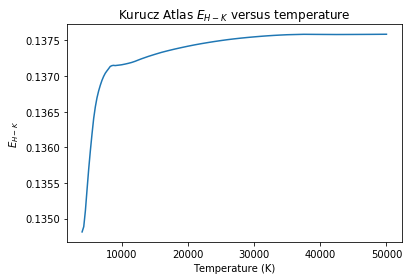

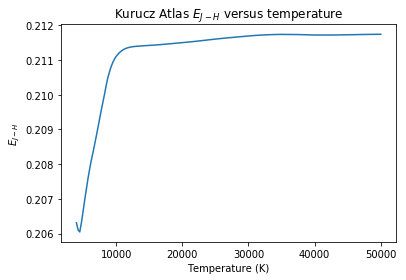

In [10]:
plt.plot(tempslist, KrczEhk)
plt.title("Kurucz Atlas $E_{H-K}$ versus temperature")
plt.xlabel("Temperature (K)")
plt.ylabel('$E_{H-K}$')
plt.show()

plt.plot(tempslist, KrczEjh)
plt.title("Kurucz Atlas $E_{J-H}$ versus temperature")
plt.xlabel("Temperature (K)")
plt.ylabel('$E_{J-H}$')
plt.show()